In [208]:
import os, os.path
import numpy as np
import pandas as pd
import model_attributes as ma
from attribute_table import AttributeTable
import model_afolu as mafl
import model_ippu as mi
import model_circular_economy as mc
import model_energy as me
import model_electricity as ml
import model_socioeconomic as se
from model_socioeconomic import Socioeconomic
import setup_analysis as sa
import sisepuede as ssp
import support_functions as sf
import importlib
import time
import warnings
import matplotlib.pyplot as plt
import sql_utilities as sq
from typing import *
import sqlalchemy
import sql_utilities as sqlutil
import time
importlib.reload(ma)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(mafl)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)
importlib.reload(ml)

warnings.filterwarnings("ignore")

import logging
def _setup_logger(namespace: str, fn_out: Union[str, None] = None) -> None:
    global logger
    
    format_str = "%(asctime)s - %(levelname)s - %(message)s"
    # configure
    if fn_out is not None:
        logging.basicConfig(
            filename = fn_out,
            filemode = "w",
            format = format_str,
            level = logging.DEBUG
        )
    else:
        logging.basicConfig(
            format = format_str,
            level = logging.DEBUG
        )
        
    logger = logging.getLogger(namespace)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter(format_str)
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    logger.addHandler(ch)

    return logger

_setup_logger(__name__, os.path.join(os.getcwd(), "log_energy_testing.log"))

<Logger __main__ (DEBUG)>

In [30]:
tab = sa.model_attributes.dict_attributes.get("abbreviation_subsector").table
subsecs = set(tab[tab["sector"] == "Energy"]["subsector"])
subsecs

{'Carbon Capture and Sequestration',
 'Energy Fuels',
 'Energy Storage',
 'Energy Technology',
 'Fugitive Emissions',
 'Industrial Energy',
 'Stationary Combustion and Other Energy',
 'Transportation',
 'Transportation Demand'}

In [665]:
importlib.reload(ma)
importlib.reload(sa)
importlib.reload(mafl)
importlib.reload(me)
#importlib.reload(mafl)

warnings.filterwarnings("ignore")

#df_cs_integrated = pd.read_csv(os.path.join(sa.dir_tmp, "temporary_full_inputs.csv"))
#df_cs_integrated = df_cs_integrated[
#    df_cs_integrated["strategy_id"].isin([0])
#].reset_index(drop = True)

df_cs_integrated = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))
df_cs_integrated = pd.read_csv(
    os.path.join(sa.dir_tmp, "temporary_full_inputs.csv")
)
df_cs_integrated = df_cs_integrated[df_cs_integrated["strategy_id"] == 0].reset_index(drop = True)
vars_try = [x for x in df_cs_integrated.columns if x.startswith("fuelefficiency_") and ("road_light" in x)]
for x in vars_try:
    df_cs_integrated[x] = min(np.array(df_cs_integrated[x]))

    
model_afolu = mafl.AFOLU(sa.model_attributes);
model_circecon = mc.CircularEconomy(sa.model_attributes);
model_ippu = mi.IPPU(sa.model_attributes);
model_energy = me.NonElectricEnergy(sa.model_attributes);

# 
df_project_afolu = model_afolu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_afolu], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ce = model_circecon.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ce], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ip = model_ippu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ip], sa.model_attributes, "concatenate")

# pass integrated df
df_project_en = model_energy.project(df_cs_integrated);
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_en], sa.model_attributes, "concatenate")



In [609]:
importlib.reload(sf)
importlib.reload(ma)
importlib.reload(sa)
importlib.reload(ml)
model_elec = ml.ElectricEnergy(sa.model_attributes, sa.dir_jl, sa.dir_ref_nemo, logger = logger);



2023-02-25 10:12:50,053 - INFO - Successfully read NemoMod input table data from /Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/nemo_mod/SpecifiedDemandProfile.csv
2023-02-25 10:12:50,053 - INFO - Successfully read NemoMod input table data from /Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/nemo_mod/SpecifiedDemandProfile.csv
2023-02-25 10:12:50,063 - INFO - Successfully read NemoMod input table data from /Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/nemo_mod/CapacityFactor.csv
2023-02-25 10:12:50,063 - INFO - Successfully read NemoMod input table data from /Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/nemo_mod/CapacityFactor.csv
2023-02-25 10:12:50,153 - INFO - Calling Julia API...
2023-02-25 10:12:50,153 - INFO - Calling Julia API...
2023-02-25 10:12:50,214 - DEBUG - 	Successfully activated Julia with compiled_modules = False
2023-02-25 10:12:50,214 - DEBUG - 	Successfully activated Julia with compiled_modules 

In [654]:
os.remove(sa.fp_sqlite_nemomod_db_tmp) if os.path.exists(sa.fp_sqlite_nemomod_db_tmp) else None
engine = sqlalchemy.create_engine(f"sqlite:///{sa.fp_sqlite_nemomod_db_tmp}")
t0 = time.time()
df_test = model_elec.project(df_cs_integrated, engine = engine, regions = "brazil")
t1 = time.time()

2023-02-25 12:04:11,014 - INFO - 	Path to temporary NemoMod database '/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/tmp/nemomod_intermediate_database.sqlite' not found. Creating...
2023-02-25 12:04:11,014 - INFO - 	Path to temporary NemoMod database '/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/tmp/nemomod_intermediate_database.sqlite' not found. Creating...


2023-25-Feb 12:04:11.049 Opened SQLite database at /Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/tmp/nemomod_intermediate_database.sqlite.
2023-25-Feb 12:04:11.112 Added NEMO structure to SQLite database at /Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/tmp/nemomod_intermediate_database.sqlite.
2023-25-Feb 12:04:13.699 Started modeling scenario.
2023-25-Feb 12:05:03.466 Finished modeling scenario.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/vg6Tx/src/scenario_calculation.jl:6107
2023-02-25 12:05:03,936 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>
2023-02-25 12:05:03,936 - INFO - NemoMod ran successfully with the following status: <PyCall.jlwrap OPTIMAL>


In [668]:
df_return = [df_cs_integrated, df_test]
df_return = [sf.merge_output_df_list(df_return, sa.model_attributes, "concatenate")]
df_return.append(model_energy.project(df_return[0], subsectors_project = sa.model_attributes.subsec_name_fgtv))




In [619]:
df_sad = sq.sql_table_to_df(engine, "ResidualCapacity")
prod = df_sad[
    (df_sad["y"] == "1033")
]#.sort_values(by = ["f"])
prod


,id,r,t,y,val
462,463,brazil,pp_biogas,1033,0.000000
463,464,brazil,pp_biomass,1033,0.000000
464,465,brazil,pp_coal,1033,1.440581
465,466,brazil,pp_coal_ccs,1033,0.000000
466,467,brazil,pp_gas,1033,0.000000
467,468,brazil,pp_gas_ccs,1033,0.000000
468,469,brazil,pp_geothermal,1033,0.000000
469,470,brazil,pp_hydropower,1033,96.578922
470,471,brazil,pp_nuclear,1033,0.000000
471,472,brazil,pp_ocean,1033,0.000000


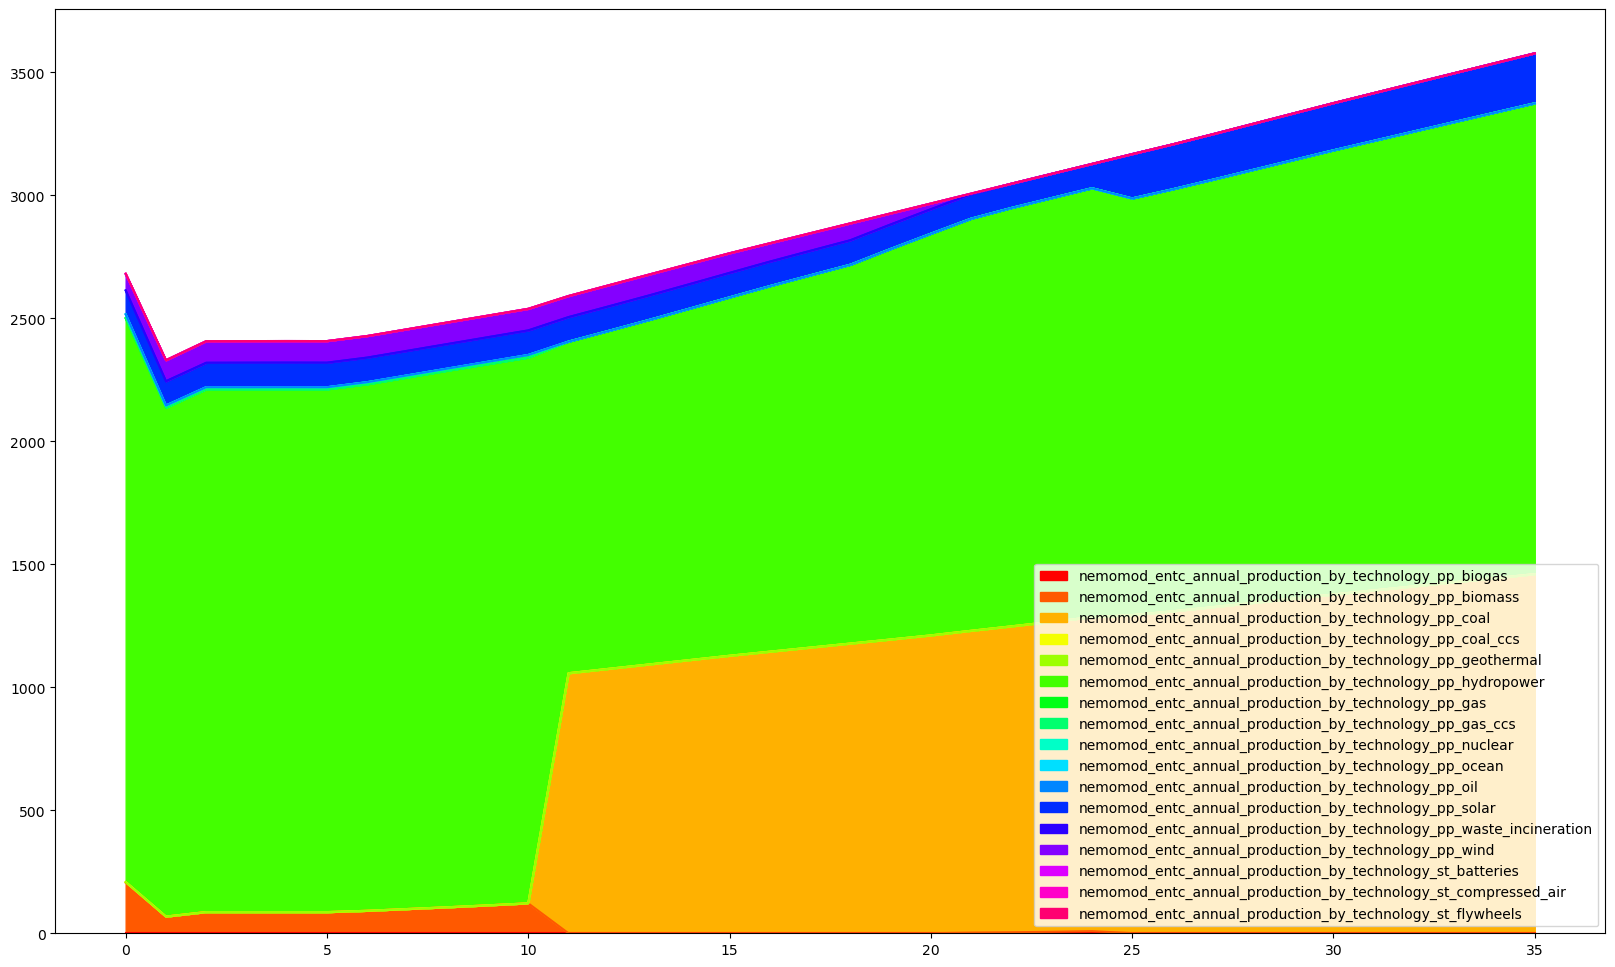

In [626]:


#df_filt = df_out[
#    df_out[sisepuede.key_primary].isin([primary_id])
#]


fig, ax = plt.subplots(figsize = (20, 12))
palette_func = plt.cm.hsv

if True:
    
    df = sa.model_attributes.get_standard_variables(
        df_test,
        #sisepuede.models.model_electricity.modvar_entc_nemomod_discounted_capital_investment
        model_elec.modvar_entc_nemomod_production_by_technology
        #sisepuede.models.model_energy.modvar_fgtv_emissions_ch4
    )
    for k in df.columns:
        df[k] = sf.vec_bounds(np.array(df[k]), (0, np.inf))
    
    m, n = df.shape
    colors = [palette_func(x/n) for x in range(n)]
    
    df.plot.area(ax = ax, color = colors)
else:
    sa.model_attributes.get_standard_variables(
        df_cs_integrated,
        model_elec.modvar_entc_nemomod_residual_capacity
    ).plot.area(ax = ax)



In [534]:
vector_reference_time_period = list(df_cs_integrated["time_period"])
dfs = model_elec.retrieve_nemomod_tables_fuel_production_demand_and_trade(
    engine,
    vector_reference_time_period,
    df_elec_trajectories = df_cs_integrated
)


In [675]:
import sqlalchemy
import sql_utilities as sqlutil
fp = "/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/out/sisepuede_run_2023-02-25T17;15;26.707643/sisepuede_run_2023-02-25T17;15;26.707643_output_database.sqlite"
engine2 = sqlalchemy.create_engine(f"sqlite:///{fp}")

df = sqlutil.sql_table_to_df(engine2, "MODEL_OUTPUT")




array(['chile', 'ecuador', 'mexico'], dtype=object)

In [673]:

model_elec.model_attributes.get_standard_variables(
    dfs,
    model_elec.modvar_enfu_energy_demand_by_fuel_total,
    expand_to_all_cats = True
).iloc[0]


fuel_biofuels                    0.110412
fuel_biogas                      0.000000
fuel_biomass                     1.795100
fuel_coal                        1.533799
fuel_coal_deposits               0.000000
fuel_coke                        1.110225
fuel_crude                      48.248515
fuel_diesel                     10.509182
fuel_electricity                25.455264
fuel_furnace_gas                 0.070379
fuel_gasoline                   24.430809
fuel_geothermal                 20.065175
fuel_hydrocarbon_gas_liquids     0.126803
fuel_hydrogen                    0.067422
fuel_hydropower                  0.000000
fuel_kerosene                    0.009877
fuel_natural_gas                10.094790
fuel_natural_gas_unprocessed     0.000000
fuel_nuclear                     0.000000
fuel_ocean                       0.000000
fuel_oil                         2.780412
fuel_other                       0.000000
fuel_solar                      47.121904
fuel_waste                       0

In [527]:
importlib.reload(sf)
importlib.reload(ma)
importlib.reload(sa)
importlib.reload(ml)
model_elec = ml.ElectricEnergy(sa.model_attributes, sa.dir_jl, sa.dir_ref_nemo, logger = logger);



df = model_elec.format_nemomod_table_input_activity_ratio(
    df_cs_integrated,
    regions = ["brazil"]
).get("InputActivityRatio")

df[(df["f"] != "fuel_electricity") & (df["y"].isin([1000]))]


2023-02-23 21:04:16,141 - INFO - Successfully read NemoMod input table data from /Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/nemo_mod/SpecifiedDemandProfile.csv
2023-02-23 21:04:16,141 - INFO - Successfully read NemoMod input table data from /Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/nemo_mod/SpecifiedDemandProfile.csv
2023-02-23 21:04:16,146 - INFO - Successfully read NemoMod input table data from /Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/nemo_mod/CapacityFactor.csv
2023-02-23 21:04:16,146 - INFO - Successfully read NemoMod input table data from /Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/nemo_mod/CapacityFactor.csv
2023-02-23 21:04:16,226 - INFO - Calling Julia API...
2023-02-23 21:04:16,226 - INFO - Calling Julia API...
2023-02-23 21:04:16,232 - DEBUG - 	Successfully activated Julia with compiled_modules = False
2023-02-23 21:04:16,232 - DEBUG - 	Successfully activated Julia with compiled_modules 

,id,r,t,f,m,y,val
36,37,brazil,fp_hydrogen_gasification,fuel_coal,generate,1000,1.967000
72,73,brazil,fp_hydrogen_reformation,fuel_natural_gas,generate,1000,1.315000
144,145,brazil,fp_natural_gas,fuel_natural_gas_unprocessed,generate,1000,1.000000
180,181,brazil,fp_petroleum_refinement,fuel_crude,generate,1000,1.086957
216,217,brazil,me_coal,fuel_coal_deposits,generate,1000,1.002302
252,253,brazil,me_coal,fuel_diesel,generate,1000,0.007826
324,325,brazil,me_coal,fuel_gasoline,generate,1000,0.000460
360,361,brazil,me_coal,fuel_natural_gas,generate,1000,0.005064
396,397,brazil,me_crude,fuel_diesel,generate,1000,0.037634
468,469,brazil,me_crude,fuel_gasoline,generate,1000,0.002214


In [509]:
# total - entc
model_elec.model_attributes.get_standard_variables(
    dfs,
    model_elec.modvar_enfu_energy_demand_by_fuel_entc,
    expand_to_all_cats = True
).iloc[0]

fuel_biofuels                    0.000000
fuel_biogas                      0.000000
fuel_biomass                     0.000000
fuel_coal                        1.123091
fuel_coal_deposits               0.000000
fuel_coke                        0.000000
fuel_crude                      48.248515
fuel_diesel                      2.292410
fuel_electricity                 2.237782
fuel_furnace_gas                 0.000000
fuel_gasoline                    0.134848
fuel_geothermal                 20.001175
fuel_hydrocarbon_gas_liquids     0.000000
fuel_hydrogen                    0.000000
fuel_hydropower                  0.000000
fuel_kerosene                    0.000000
fuel_natural_gas                 0.022631
fuel_natural_gas_unprocessed     0.000000
fuel_nuclear                     0.000000
fuel_ocean                       0.000000
fuel_oil                         0.000000
fuel_other                       0.000000
fuel_solar                      47.112986
fuel_waste                       0

In [542]:
df_sad = sq.sql_table_to_df(engine, "SpecifiedAnnualDemand")
prod = df_sad[
    (df_sad["y"] == "1000")
]
prod

,id,r,f,y,val
0,1,brazil,fuel_coal,1000,3.410709
36,37,brazil,fuel_crude,1000,2.000000
72,73,brazil,fuel_diesel,1000,10.216772
108,109,brazil,fuel_electricity,1000,25.611324
144,145,brazil,fuel_gasoline,1000,24.795962
180,181,brazil,fuel_hydrocarbon_gas_liquids,1000,0.376803
216,217,brazil,fuel_hydrogen,1000,0.567422
252,253,brazil,fuel_kerosene,1000,1.009877
288,289,brazil,fuel_natural_gas,1000,10.572159
324,325,brazil,fuel_oil,1000,2.980412


In [579]:
sa.model_attributes.get_scalar(model_elec.modvar_enfu_energy_demand_by_fuel_total, "energy")

1

In [580]:
# models
tot = 7692+2936+3397+869+1145+119

# model_attributes, attribute tabl
tot += 4468 + 170

# support functions, sql util
tot += 1654 + 264

# sisepuede, sisepuede models, sisepuede output database, ex manager, file strucure, ingestion, analysis_id
tot += 379 + 786 + 1183 + 596 + 551 + 1343 + 203

# sampling unit
tot += 2214 

# lhs design, iterative db, ordered direct product table
tot += 499 + 1647 + 364

tot

32479

In [573]:
# modvar_enfu_exports_adjusted_fuel
# modvar_enfu_imports_fuel
# modvar_enfu_energy_demand_by_fuel_entc
# modvar_enfu_energy_demand_by_fuel_total
# modvar_enfu_production_fuel
# modvar_enfu_transmission_loss_electricity

v2 = model_elec.model_attributes.get_standard_variables(
    df_test,
    model_elec.modvar_enfu_energy_demand_by_fuel_total,
    expand_to_all_cats = True
).iloc[0]
v2 += model_elec.model_attributes.get_standard_variables(
    df_test,
    model_elec.modvar_enfu_exports_adjusted_fuel,
    expand_to_all_cats = True
).iloc[0]
v2 += model_elec.model_attributes.get_standard_variables(
    df_test,
    model_elec.modvar_enfu_transmission_loss_electricity,
    expand_to_all_cats = True
).iloc[0]

model_elec.model_attributes.get_standard_variables(
    df_test,
    model_elec.modvar_enfu_transmission_loss_electricity,
    expand_to_all_cats = True
).iloc[0]

fuel_biofuels                   0.000000
fuel_biogas                     0.000000
fuel_biomass                    0.000000
fuel_coal                       0.000000
fuel_coal_deposits              0.000000
fuel_coke                       0.000000
fuel_crude                      0.000000
fuel_diesel                     0.000000
fuel_electricity                1.679517
fuel_furnace_gas                0.000000
fuel_gasoline                   0.000000
fuel_geothermal                 0.000000
fuel_hydrocarbon_gas_liquids    0.000000
fuel_hydrogen                   0.000000
fuel_hydropower                 0.000000
fuel_kerosene                   0.000000
fuel_natural_gas                0.000000
fuel_natural_gas_unprocessed    0.000000
fuel_nuclear                    0.000000
fuel_ocean                      0.000000
fuel_oil                        0.000000
fuel_other                      0.000000
fuel_solar                      0.000000
fuel_waste                      0.000000
fuel_wind       

In [566]:
# modvar_enfu_exports_adjusted_fuel
# modvar_enfu_imports_fuel
# modvar_enfu_energy_demand_by_fuel_entc
# modvar_enfu_energy_demand_by_fuel_total
# modvar_enfu_production_fuel


v1 = model_elec.model_attributes.get_standard_variables(
    df_test,
    model_elec.modvar_enfu_imports_fuel,
    expand_to_all_cats = True
).iloc[0]
v1 += model_elec.model_attributes.get_standard_variables(
    df_test,
    model_elec.modvar_enfu_production_fuel,
    expand_to_all_cats = True
).iloc[0]
v1


fuel_biofuels                    0.000000
fuel_biogas                      0.000000
fuel_biomass                     0.000000
fuel_coal                        4.533799
fuel_coal_deposits               0.000000
fuel_coke                        0.000000
fuel_crude                      50.248515
fuel_diesel                     14.331594
fuel_electricity                27.991944
fuel_furnace_gas                 0.000000
fuel_gasoline                   24.930808
fuel_geothermal                  0.000000
fuel_hydrocarbon_gas_liquids     2.095483
fuel_hydrogen                    0.567422
fuel_hydropower                  0.000000
fuel_kerosene                    3.818938
fuel_natural_gas                10.594789
fuel_natural_gas_unprocessed     0.000000
fuel_nuclear                     0.000000
fuel_ocean                       0.000000
fuel_oil                         2.980412
fuel_other                       0.000000
fuel_solar                       0.000000
fuel_waste                       0

In [551]:
# prod + imports
arr_enfu_demands, arr_enfu_demands_distribution, arr_enfu_export, arr_enfu_imports, arr_enfu_production = model_energy.project_enfu_production_and_demands(df_cs_integrated, target_energy_units = model_elec.model_attributes.configuration.get("energy_units_nemomod")) 
tuple_enfu_production_and_demands = arr_enfu_demands, arr_enfu_demands_distribution, arr_enfu_export, arr_enfu_imports, arr_enfu_production

arr_enfu_demands + arr_enfu_export


arr_frac = sa.model_attributes.get_standard_variables(
    df_cs_integrated,
    model_elec.modvar_enfu_frac_fuel_demand_imported,
    return_type = "array_base",
    expand_to_all_cats = True
)


In [440]:
# demands from other sectors + exports  
dem = 25.611324
dem + 2.237782


27.849106

In [561]:
model_elec.model_attributes.get_standard_variables(
    dfs,
    model_elec.modvar_enfu_energy_demand_by_fuel_total,
    expand_to_all_cats = True
).iloc[0]

fuel_biofuels                    0.110412
fuel_biogas                      0.000000
fuel_biomass                     1.795100
fuel_coal                        1.533799
fuel_coal_deposits               0.000000
fuel_coke                        1.110225
fuel_crude                      48.248515
fuel_diesel                     10.509182
fuel_electricity                25.455264
fuel_furnace_gas                 0.070379
fuel_gasoline                   24.430809
fuel_geothermal                 20.065175
fuel_hydrocarbon_gas_liquids     0.126803
fuel_hydrogen                    0.067422
fuel_hydropower                  0.000000
fuel_kerosene                    0.009877
fuel_natural_gas                10.094790
fuel_natural_gas_unprocessed     0.000000
fuel_nuclear                     0.000000
fuel_ocean                       0.000000
fuel_oil                         2.780412
fuel_other                       0.000000
fuel_solar                      47.121904
fuel_waste                       0

In [333]:
model_elec.model_attributes.get_standard_variables(
    dfs,
    model_elec.modvar_enfu_energy_demand_by_fuel_entc,
    expand_to_all_cats = True
).iloc[0]

fuel_biofuels                    0.000000
fuel_biogas                      0.000000
fuel_biomass                     0.000000
fuel_coal                        1.097536
fuel_coal_deposits               0.000000
fuel_coke                        0.000000
fuel_crude                      48.032927
fuel_diesel                      1.900064
fuel_electricity                 1.867562
fuel_furnace_gas                 0.000000
fuel_gasoline                    0.111768
fuel_geothermal                 18.193817
fuel_hydrocarbon_gas_liquids     0.000000
fuel_hydrogen                    0.000000
fuel_hydropower                  0.000000
fuel_kerosene                    0.000000
fuel_natural_gas                 0.020504
fuel_natural_gas_unprocessed     0.000000
fuel_nuclear                     0.000000
fuel_ocean                       0.000000
fuel_oil                         0.000000
fuel_other                       0.000000
fuel_solar                      47.281848
fuel_waste                       0

In [334]:
# modvar_enfu_exports_adjusted_fuel
# modvar_enfu_imports_fuel
# modvar_enfu_energy_demand_by_fuel_entc
# modvar_enfu_energy_demand_by_fuel_total
# modvar_enfu_production_fuel

model_elec.model_attributes.get_standard_variables(
    dfs,
    model_elec.modvar_enfu_energy_demand_by_fuel_total,
    expand_to_all_cats = True
).iloc[0]

fuel_biofuels                    0.110412
fuel_biogas                      0.000000
fuel_biomass                     1.795100
fuel_coal                        1.508245
fuel_coal_deposits               0.000000
fuel_coke                        1.110225
fuel_crude                      48.032927
fuel_diesel                     10.116836
fuel_electricity                24.942207
fuel_furnace_gas                 0.070379
fuel_gasoline                   24.407730
fuel_geothermal                 18.257817
fuel_hydrocarbon_gas_liquids     0.126803
fuel_hydrogen                    0.067422
fuel_hydropower                  0.000000
fuel_kerosene                    0.009877
fuel_natural_gas                10.092663
fuel_natural_gas_unprocessed     0.000000
fuel_nuclear                     0.000000
fuel_ocean                       0.000000
fuel_oil                         2.780412
fuel_other                       0.000000
fuel_solar                      47.290766
fuel_waste                       0

In [269]:
df_prod = sq.sql_table_to_df(engine, "vproductionbytechnologyannual")
prod = df_prod[
    (df_prod["y"] == "1000") &
    (df_prod["f"] == "fuel_electricity")
]["val"].sum()

df_prod[df_prod["y"] == "1000"].sort_values(by = ["f"])



Engine(sqlite:////Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/tmp/nemomod_intermediate_database.sqlite)

In [153]:
df_prod[
    (df_prod["y"] == "1000") &
    (df_prod["f"] == "fuel_electricity")
]["val"].sum() - 2.198311

25.280575138589082

In [1475]:
df = sq.sql_table_to_df(engine, "CapitalCost")
df[df["y"] == "1000"]

,id,r,t,y,val
0,1,costa_rica,pp_biogas,1000,4335.0
1,2,costa_rica,pp_biomass,1000,4525.0
2,3,costa_rica,pp_coal,1000,4074.0
3,4,costa_rica,pp_coal_ccs,1000,6625.0
4,5,costa_rica,pp_gas,1000,1131.5
5,6,costa_rica,pp_gas_ccs,1000,2845.0
6,7,costa_rica,pp_geothermal,1000,3076.0
7,8,costa_rica,pp_hydropower,1000,3083.0
8,9,costa_rica,pp_nuclear,1000,7289.0
9,10,costa_rica,pp_ocean,1000,3998.0


In [1469]:
df = sq.sql_table_to_df(engine, "vproductionbytechnologyannual")
df[df["y"] == "1035"].sort_values(by = ["t"])



,r,t,f,y,val,solvedtm
445,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1035,5.545257e-01,2023-02-14 18:53:03.357
45,costa_rica,fp_natural_gas,fuel_natural_gas,1035,9.676655e+00,2023-02-14 18:53:03.357
667,costa_rica,fp_natural_gas,fuel_hydrocarbon_gas_liquids,1035,2.814285e-01,2023-02-14 18:53:03.357
10,costa_rica,fp_petroleum_refinement,fuel_oil,1035,9.383059e-01,2023-02-14 18:53:03.357
809,costa_rica,fp_petroleum_refinement,fuel_diesel,1035,1.982797e+01,2023-02-14 18:53:03.357
736,costa_rica,fp_petroleum_refinement,fuel_kerosene,1035,5.740028e+00,2023-02-14 18:53:03.357
432,costa_rica,fp_petroleum_refinement,fuel_gasoline,1035,3.199590e+01,2023-02-14 18:53:03.357
323,costa_rica,fp_petroleum_refinement,fuel_hydrocarbon_gas_liquids,1035,2.671333e+00,2023-02-14 18:53:03.357
857,costa_rica,me_coal,fuel_coal,1035,2.277937e+00,2023-02-14 18:53:03.357
776,costa_rica,me_crude,fuel_crude,1035,5.887247e+01,2023-02-14 18:53:03.357


In [1452]:
attribute_fuel = model_elec.model_attributes.get_attribute_table("Energy Fuels")

In [ ]:
df = sq.sql_table_to_df(engine, "MinShareProduction")
df[df["y"] == "1035"]

In [1245]:
df = sq.sql_table_to_df(engine, "vusenn")
#df[df["t"] == "st_batteries"]
df.drop("solvedtm", axis = 1).groupby(["r", "f", "y"]).agg({"r": "first", "f": "first", "y": "first", "val": "sum"}).reset_index(drop = True)




,r,f,y,val
0,costa_rica,fuel_QUANTITY_PRODUCED,1000,89.810853
1,costa_rica,fuel_QUANTITY_PRODUCED,1001,91.259551
2,costa_rica,fuel_QUANTITY_PRODUCED,1002,92.546140
3,costa_rica,fuel_QUANTITY_PRODUCED,1003,93.666922
4,costa_rica,fuel_QUANTITY_PRODUCED,1004,94.845710
...,...,...,...,...
446,costa_rica,fuel_waste,1031,0.323823
447,costa_rica,fuel_waste,1032,0.332237
448,costa_rica,fuel_waste,1033,0.340913
449,costa_rica,fuel_waste,1034,0.349861


In [1258]:
df = sq.sql_table_to_df(engine, "vdemandannualnn")
df[df["f"] == "fuel_coal"].sort_values(by = ["y"])


,r,f,y,val,solvedtm
0,costa_rica,fuel_coal,1000,1.410709,2023-02-12 01:08:59.257
10,costa_rica,fuel_coal,1001,1.411571,2023-02-12 01:08:59.257
20,costa_rica,fuel_coal,1002,1.412224,2023-02-12 01:08:59.257
30,costa_rica,fuel_coal,1003,1.412687,2023-02-12 01:08:59.257
40,costa_rica,fuel_coal,1004,1.413239,2023-02-12 01:08:59.257
50,costa_rica,fuel_coal,1005,1.413771,2023-02-12 01:08:59.257
60,costa_rica,fuel_coal,1006,1.414363,2023-02-12 01:08:59.257
70,costa_rica,fuel_coal,1007,1.414990,2023-02-12 01:08:59.257
80,costa_rica,fuel_coal,1008,1.415682,2023-02-12 01:08:59.257
90,costa_rica,fuel_coal,1009,1.416437,2023-02-12 01:08:59.257


In [810]:
vec_time_period = list(df_elec_trajectories[model_elec.model_attributes.dim_time_period])
df = model_elec.retrieve_nemomod_table_fuel_demands(engine, vec_time_period)#.columns


In [949]:
df = model_elec.format_nemomod_table_input_activity_ratio(df_cs_integrated).get("InputActivityRatio")
df[["t", "f"]].drop_duplicates().shape

(59, 2)

<AxesSubplot: >

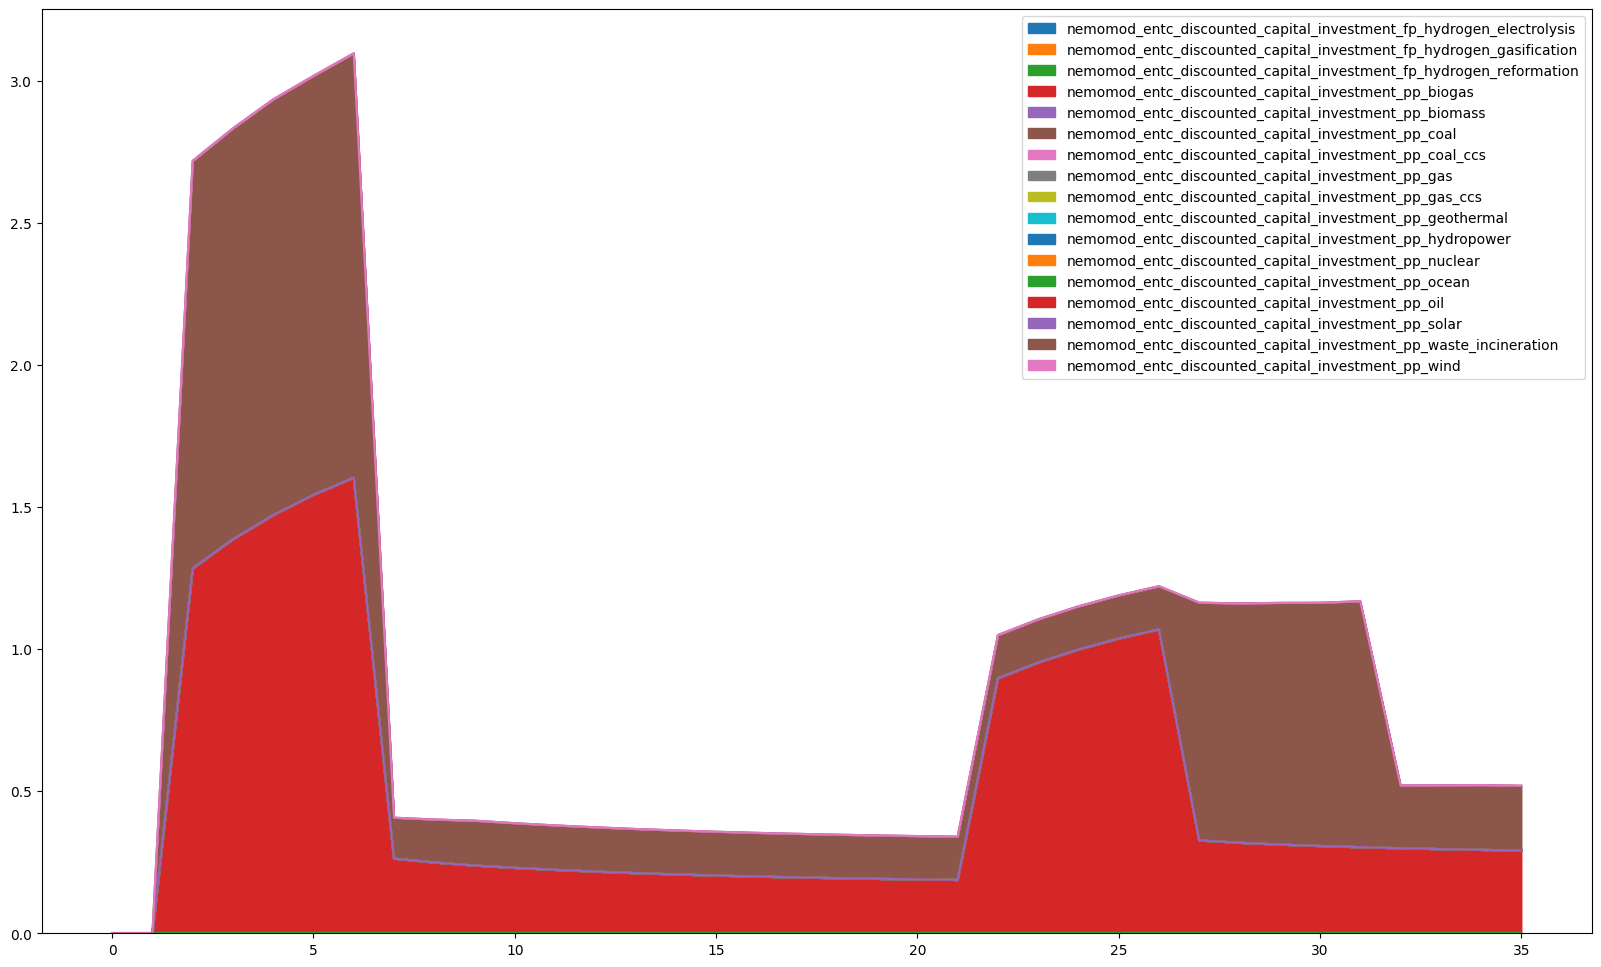

In [1196]:
vt = list(df_cs_integrated["time_period"])
fig, ax = plt.subplots(figsize = (20, 12))
model_elec.retrieve_nemomod_table_discounted_capital_invesment(engine, vt).plot.area(label = None, ax = ax)

In [1181]:
df_cost = sq.sql_table_to_df(engine, "vusenn")
df_cost[
    df_cost["y"] == "1034"
]

,r,l,f,y,val,solvedtm
12928,costa_rica,fallwd0,fuel_QUANTITY_PRODUCED,1034,3.498061,2023-02-12 01:08:59.257
12929,costa_rica,fallwd12,fuel_QUANTITY_PRODUCED,1034,3.939579,2023-02-12 01:08:59.257
12930,costa_rica,fallwd18,fuel_QUANTITY_PRODUCED,1034,3.820963,2023-02-12 01:08:59.257
12931,costa_rica,fallwd6,fuel_QUANTITY_PRODUCED,1034,3.523222,2023-02-12 01:08:59.257
12932,costa_rica,fallwe0,fuel_QUANTITY_PRODUCED,1034,1.460466,2023-02-12 01:08:59.257
...,...,...,...,...,...,...
13307,costa_rica,winterwd6,fuel_waste,1034,0.015619,2023-02-12 01:08:59.257
13308,costa_rica,winterwe0,fuel_waste,1034,0.006248,2023-02-12 01:08:59.257
13309,costa_rica,winterwe12,fuel_waste,1034,0.006248,2023-02-12 01:08:59.257
13310,costa_rica,winterwe18,fuel_waste,1034,0.006248,2023-02-12 01:08:59.257


In [1216]:
df_cost = sq.sql_table_to_df(engine, "vproductionbytechnologyannual")
df_cost[
    df_cost["y"].isin(["1030"])
].sort_values(by = ["t"])

,r,t,f,y,val,solvedtm
81,costa_rica,fp_hydrogen_gasification,fuel_hydrogen,1030,5.543851e-01,2023-02-12 01:08:59.257
538,costa_rica,fp_natural_gas,fuel_natural_gas,1030,9.417463e+00,2023-02-12 01:08:59.257
426,costa_rica,fp_natural_gas,fuel_hydrocarbon_gas_liquids,1030,2.738904e-01,2023-02-12 01:08:59.257
935,costa_rica,fp_petroleum_refinement,fuel_hydrocarbon_gas_liquids,1030,2.538362e+00,2023-02-12 01:08:59.257
898,costa_rica,fp_petroleum_refinement,fuel_kerosene,1030,5.454305e+00,2023-02-12 01:08:59.257
618,costa_rica,fp_petroleum_refinement,fuel_gasoline,1030,3.040323e+01,2023-02-12 01:08:59.257
333,costa_rica,fp_petroleum_refinement,fuel_oil,1030,8.915995e-01,2023-02-12 01:08:59.257
1033,costa_rica,fp_petroleum_refinement,fuel_diesel,1030,1.884099e+01,2023-02-12 01:08:59.257
75,costa_rica,me_coal,fuel_coal,1030,2.272881e+00,2023-02-12 01:08:59.257
266,costa_rica,me_crude,fuel_crude,1030,5.598178e+01,2023-02-12 01:08:59.257


In [1179]:
df_cost = sq.sql_table_to_df(engine, "TechnologyToStorage")#"vproductionbytechnologyannual")
#df_cost[
#    df_cost["t"].isin(["st_batteries"])   
#]
df_cost

,id,r,t,s,m,val
0,1,costa_rica,st_batteries,st_batteries,store,1.0
1,2,costa_rica,st_compressed_air,st_compressed_air,store,1.0
2,3,costa_rica,st_flywheels,st_flywheels,store,1.0


In [1137]:
#[x for x in engine.table_names() if x.startswith("v")]
df_cost = sq.sql_table_to_df(engine, "vtotalcapacityannual")#"vproductionbytechnologyannual")
df_cost[
    df_cost["t"].isin(["pp_oil"]) &
    df_cost["y"].isin(["1001", "1002"])
]

,r,t,y,val,solvedtm
34,costa_rica,pp_oil,1001,466.45,2023-02-12 01:01:35.578
61,costa_rica,pp_oil,1002,466.45,2023-02-12 01:01:35.578


In [1138]:
#
# df_check = model_elec.format_nemomod_table_costs_technology(df_cs_integrated)
#
df_msp = sq.sql_table_to_df(engine, "MinShareProduction")
df_msp[
    df_msp["y"] == "1002"
]



,id,r,t,f,y,val
2,3,costa_rica,supply_fuel_coal,fuel_coal,1002,0.100
38,39,costa_rica,supply_fuel_crude,fuel_crude,1002,0.200
74,75,costa_rica,supply_fuel_diesel,fuel_diesel,1002,0.100
110,111,costa_rica,supply_fuel_electricity,fuel_electricity,1002,0.080
146,147,costa_rica,supply_fuel_gasoline,fuel_gasoline,1002,0.150
182,183,costa_rica,supply_fuel_hydrogen,fuel_hydrogen,1002,0.025
218,219,costa_rica,supply_fuel_kerosene,fuel_kerosene,1002,0.100
254,255,costa_rica,supply_fuel_natural_gas,fuel_natural_gas,1002,0.200
290,291,costa_rica,supply_fuel_oil,fuel_oil,1002,0.150


In [853]:
#model_elec.dict_entc_fuel_categories_to_fuel_variables
model_elec.model_attributes.get_variable_categories(
    model_energy.modvar_enfu_imports_fuel
)

['fuel_coal', 'fuel_natural_gas', 'fuel_oil']

In [611]:
df_elec_trajectories = df_cs_integrated
attribute_time_period: AttributeTable = None
attribute_fuel: Union[AttributeTable, None] = None
attribute_technology: Union[AttributeTable, None] = None

attr_enfu = model_elec.model_attributes.get_attribute_table(model_elec.model_attributes.subsec_name_enfu) if not isinstance(attribute_fuel, AttributeTable) else attribute_fuel
attr_entc = model_elec.model_attributes.get_attribute_table(model_elec.model_attributes.subsec_name_entc) if not isinstance(attribute_technology, AttributeTable) else attribute_technology
pycat_enfu = model_elec.model_attributes.get_subsector_attribute(model_elec.subsec_name_enfu, "pycategory_primary")

dict_tech_info = model_elec.get_tech_info_dict(attribute_fuel = attribute_fuel)
# cat to fuel dictionary
dict_techs_to_fuel = model_elec.model_attributes.get_ordered_category_attribute(
    model_elec.model_attributes.subsec_name_entc,
    f"electricity_generation_{pycat_enfu}",
    return_type = dict,
    skip_none_q = True,
    clean_attribute_schema_q = True
)
dict_fuel_to_techs = sf.reverse_dict(dict_techs_to_fuel, allow_multi_keys = True)

cats_enfu_fuel_ordered = [x for x in attr_enfu.key_values if (x in dict_fuel_to_techs.keys())]
inds_enfu_extract = [attr_enfu.get_key_value_index(x) for x in cats_enfu_fuel_ordered]


In [ ]:
# UNDEFINED
cats_entc_ordered_by_fuels = [dict_fuel_to_techs.get(x) for x in cats_enfu_fuel_ordered]
cats_entc_ordered_by_techs = [x for x in attr_entc.key_values if (x in cats_entc_ordered_by_fuels)]

In [610]:
# set required variables for emission factors and initialize output dictionary
list_modvars_enfu_to_tech = [
    (model_elec.modvar_enfu_ef_combustion_stationary_ch4, model_elec.modvar_entc_ef_scalar_ch4),
    (model_elec.modvar_enfu_ef_combustion_co2, model_elec.modvar_entc_ef_scalar_co2),
    (model_elec.modvar_enfu_ef_combustion_stationary_n2o, model_elec.modvar_entc_ef_scalar_n2o)
]

df_out = []

In [619]:
modvars = 0, list_modvars_enfu_to_tech[0]
ind, modvars = modvars
modvar, modvar_scalar = modvars
# get the fuel factors
arr_enfu_tmp = model_elec.model_attributes.get_standard_variables(
    df_elec_trajectories, 
    modvar, 
    override_vector_for_single_mv_q = True, 
    return_type = "array_base", 
    expand_to_all_cats = False
)

In [628]:
dict_pp_tech_to_fuel = dict_tech_info.get("dict_pp_tech_to_fuel")

cats_entc_ordered = [x for x in attr_entc.key_values if x in dict_pp_tech_to_fuel.keys()]
inds_enfu_extract = [
    attr_enfu.get_key_value_index(dict_pp_tech_to_fuel.get(x)) for x in cats_entc_ordered
]


inds_enfu_extract

[1, 2, 3, 3, 16, 16, 11, 14, 18, 19, 20, 22, 23, 24]

In [631]:
dict_tech_info.get("dict_fuel_to_pp_tech")

{'fuel_geothermal': ['pp_geothermal'],
 'fuel_ocean': ['pp_ocean'],
 'fuel_solar': ['pp_solar'],
 'fuel_biomass': ['pp_biomass'],
 'fuel_nuclear': ['pp_nuclear'],
 'fuel_waste': ['pp_waste_incineration'],
 'fuel_hydropower': ['pp_hydropower'],
 'fuel_coal': ['pp_coal', 'pp_coal_ccs'],
 'fuel_wind': ['pp_wind'],
 'fuel_biogas': ['pp_biogas'],
 'fuel_oil': ['pp_oil'],
 'fuel_natural_gas': ['pp_gas', 'pp_gas_ccs']}

<AxesSubplot: >

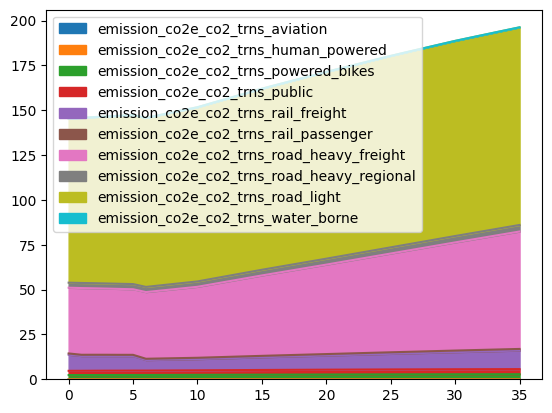

In [156]:
sa.model_attributes.get_standard_variables(
    df_project_en,
    model_energy.modvar_trns_emissions_co2
).plot.area()

# so, private and public passenger km are too low

In [35]:
sa.model_attributes.get_standard_variables(
    df_cs_integrated,
    model_energy.modvar_trde_demand_initial_pkm_per_capita
).head()

,deminit_trde_private_and_public_per_capita_passenger_km,deminit_trde_regional_per_capita_passenger_km
0,0.008526,0.005480
1,0.008501,0.005401
2,0.008501,0.005401
3,0.008501,0.005401
4,0.008501,0.005401


<AxesSubplot:>

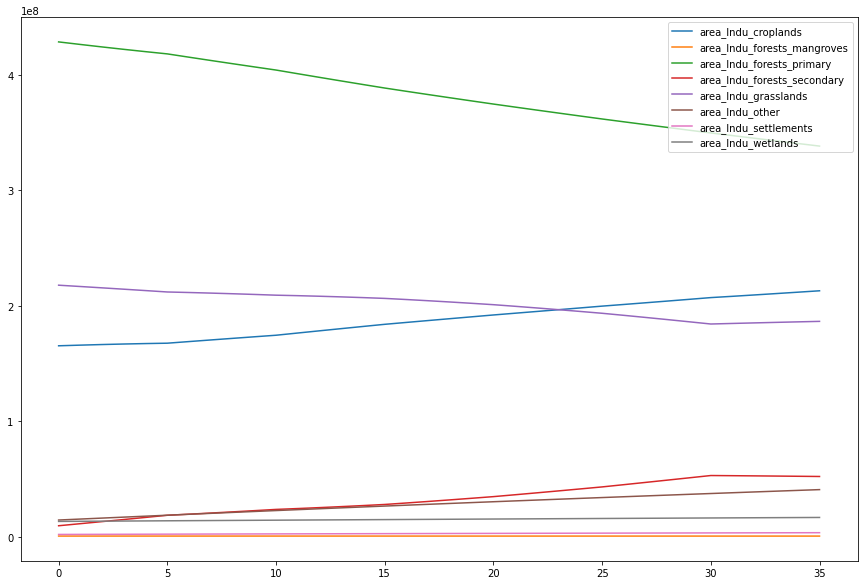

In [713]:
fix, ax = plt.subplots(figsize = (15, 10))
df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion" not in x)]].plot(ax = ax)

In [261]:
print(sa.model_attributes.get_attribute_table("Land Use").key_values)
model_afolu.arrs_lndu_land_conv[0][:, 1]

['croplands', 'forests_mangroves', 'forests_primary', 'forests_secondary', 'grasslands', 'other', 'settlements', 'wetlands']


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.10646039e+01, 2.17770575e+04])

In [201]:
model_afolu.arrs_lndu_land_conv[1][:, 3]

array([1.42070899e+06, 0.00000000e+00, 0.00000000e+00, 8.52649751e+06,
       2.05676235e+06, 2.84337965e+06, 2.06758350e+03, 6.72316709e+04])

In [172]:
df_input[[x for x in df_input.columns if ("pij_" in x) and ("forests_secondary" in x)]]

,pij_lndu_croplands_to_forests_secondary,pij_lndu_forests_mangroves_to_forests_secondary,pij_lndu_forests_primary_to_forests_secondary,pij_lndu_forests_secondary_to_croplands,pij_lndu_forests_secondary_to_forests_mangroves,pij_lndu_forests_secondary_to_forests_primary,pij_lndu_forests_secondary_to_forests_secondary,pij_lndu_forests_secondary_to_grasslands,pij_lndu_forests_secondary_to_other,pij_lndu_forests_secondary_to_settlements,pij_lndu_forests_secondary_to_wetlands,pij_lndu_grasslands_to_forests_secondary,pij_lndu_other_to_forests_secondary,pij_lndu_settlements_to_forests_secondary,pij_lndu_wetlands_to_forests_secondary
0,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
1,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
2,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
3,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
4,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
5,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
6,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
7,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
8,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826
9,0.025121,0,0,0.007685,0,0.001,0.97748,0.012241,0.001139,0.000153,0.000302,0.017829,0.051093,0.000608,0.015826


In [43]:

importlib.reload(ma)
importlib.reload(mi)

warnings.filterwarnings("ignore")

df_cs_integrated = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))

#model_afolu = mafl.AFOLU(sa.model_attributes);
#model_circecon = mc.CircularEconomy(sa.model_attributes);
model_ippu = mi.IPPU(sa.model_attributes);
model_energy = me.NonElectricEnergy(sa.model_attributes);

# 
df_project_afolu = model_afolu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_afolu], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ce = model_circecon.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ce], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ip = model_ippu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ip], sa.model_attributes, "concatenate")

# pass in


In [ ]:
df_

In [928]:
?sa.model_attributes.get_optional_or_integrated_standard_variable

Signature:
sa.model_attributes.get_optional_or_integrated_standard_variable(
    df_in: pandas.core.frame.DataFrame,
    var_integrated: str,
    var_optional: str,
    override_vector_for_single_mv_q: bool = False,
    return_type: str = 'data_frame',
    var_bounds=None,
    force_boundary_restriction: bool = True,
) -> tuple
Docstring: <no docstring>
File:      ~/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py
Type:      method


In [943]:
def funct(y, this: bool = False, this2: int = 0):
    
    out = y**this2 if this else (y*(this2**2.3))
    return out

def test(x, **kwargs):
    x = funct(x, **kwargs)

    print(f"x: {x}")
    
test(3, this = False, this2 = 3)

x: 37.540507598529544


In [ ]:
## importlib.reload(ma)
importlib.reload(sa)
importlib.reload(me)
#importlib.reload(mafl)

warnings.filterwarnings("ignore")

df_cs_integrated = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))

model_afolu = mafl.AFOLU(sa.model_attributes);
model_circecon = mc.CircularEconomy(sa.model_attributes);
model_ippu = mi.IPPU(sa.model_attributes);
model_energy = me.NonElectricEnergy(sa.model_attributes);

# 
df_project_afolu = model_afolu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_afolu], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ce = model_circecon.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ce], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ip = model_ippu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ip], sa.model_attributes, "concatenate")

# pass integrated df
df_project_en = model_energy.project(df_cs_integrated);
#df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_en], sa.model_attributes, "concatenate")



In [65]:
#importlib.reload(ma)
#importlib.reload(sa)
importlib.reload(me)
model_energy = me.NonElectricEnergy(sa.model_attributes);
df_project_en = model_energy.project(df_cs_integrated);

In [172]:
importlib.reload(sf)
importlib.reload(me)
#df_cs_integrated = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))
model_energy = me.NonElectricEnergy(sa.model_attributes)
df_project_en = model_energy.project(df_cs_integrated)

In [66]:
#df_project_en[[x for x in df_project_en if ("emission_co2e" in x) and ("inen" in x)]]

In [53]:
importlib.reload(me)
model_energy = me.NonElectricEnergy(sa.model_attributes);
df_project_en = model_energy.project(df_cs_integrated)




,time_period,emission_co2e_ch4_ccsq_direct_air_capture,emission_co2e_co2_ccsq_direct_air_capture,emission_co2e_n2o_ccsq_direct_air_capture,energy_demand_ccsq_electric_direct_air_capture,energy_demand_ccsq_non_electric_direct_air_capture,energy_demand_ccsq_non_electric_total,energy_demand_enfu_subsector_total_pj_ccsq_fuel_biofuels,energy_demand_enfu_subsector_total_pj_ccsq_fuel_coal,energy_demand_enfu_subsector_total_pj_ccsq_fuel_coke,...,energy_demand_enfu_subsector_total_pj_ccsq_fuel_hydropower,energy_demand_enfu_subsector_total_pj_ccsq_fuel_kerosene,energy_demand_enfu_subsector_total_pj_ccsq_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_ccsq_fuel_nuclear,energy_demand_enfu_subsector_total_pj_ccsq_fuel_oil,energy_demand_enfu_subsector_total_pj_ccsq_fuel_other,energy_demand_enfu_subsector_total_pj_ccsq_fuel_solar,energy_demand_enfu_subsector_total_pj_ccsq_fuel_solid_biomass,energy_demand_enfu_subsector_total_pj_ccsq_fuel_wind,emission_co2e_subsector_total_scoe
0,0,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,0.00035,-0.622739,0.000599,1.6,6.4,6.4,0.0,0.0,0.0,...,0.0,0.0,6.272,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
#df_project_ce = model_circecon.project(df_cs_integrated)
outs = sa.model_attributes.build_varlist(sa.model_attributes.subsec_name_enfu, variable_type = "input")#"Fugitive Emissions"
outs.sort()
for k in outs:
    if k not in df_cs_integrated.columns:
        print(k)

exports_enfu_pj_fuel_coal
exports_enfu_pj_fuel_natural_gas
exports_enfu_pj_fuel_oil
imports_enfu_pj_fuel_coal
imports_enfu_pj_fuel_natural_gas
imports_enfu_pj_fuel_oil
scalar_enfu_ratio_imports_to_exports_fuel_coal
scalar_enfu_ratio_imports_to_exports_fuel_natural_gas
scalar_enfu_ratio_imports_to_exports_fuel_oil


In [586]:
df_calib = pd.read_csv("/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/preliminary_calibration_info/df_waste_var_calib.csv")
df_calib.rename(columns = {"waste_var_calib": "variable"}, inplace = True)
df_ce_ranges = pd.read_excel(sa.excel_template_path("Circular Economy", "arg", "demo", True));


In [603]:
df_input = pd.read_csv("/Users/jsyme/Downloads/data_complete_future_2022_06_13.csv")
df_barbados = df_input[df_input["nation"] == "barbados"]

df_barbados[[x for x in df_barbados.columns if ("waso" in x) and ("frac" in x) and ("initial_composition_mun" in x)]]





,frac_waso_initial_composition_mun_chemical_industrial,frac_waso_initial_composition_mun_food,frac_waso_initial_composition_mun_glass,frac_waso_initial_composition_mun_metal,frac_waso_initial_composition_mun_nappies,frac_waso_initial_composition_mun_other,frac_waso_initial_composition_mun_paper,frac_waso_initial_composition_mun_plastic,frac_waso_initial_composition_mun_rubber_leather,frac_waso_initial_composition_mun_sludge,frac_waso_initial_composition_mun_textiles,frac_waso_initial_composition_mun_wood,frac_waso_initial_composition_mun_yard
72,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
73,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
74,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
75,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
76,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
77,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
78,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
79,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
80,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165
81,0,0.584,0.0315,0.0235,0.008,0.066,0.125,0.12,0.003,0,0.0195,0.0015,0.0165


In [592]:
v = []

for subsec in sa.model_attributes.get_sector_subsectors("Circular Economy"):
    v0 = sa.model_attributes.build_varlist(subsec, variable_type = "input")
    v += list(zip([subsec for x in v0], v0))
    
df_v = pd.DataFrame(v, columns = ["subsector", "variable"])

#drops = set(df_calib["variable"]) - set(v)
#adds = list(set(v) - set(df_calib["variable"]))

#df_calib = df_calib[~df_calib["variable"].isin(drops)]

df_calib_out = pd.merge(df_v, df_calib, how = "left", on = ["variable"])
df_calib_out = pd.merge(df_calib_out, df_ce_ranges[["variable", "min_35", "max_35"]]).rename(columns = {"min_35": "Min Scalar", "max_35": "Max Scalar"}).sort_values(by = ["subsector", "variable"]).reset_index(drop = True)
df_calib_out.to_csv("/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/ref/preliminary_calibration_info/df_ce_var_calib.csv", index = None, encoding = "UTF-8")



In [10]:
vars_afolu = sa.model_attributes.build_varlist("Livestock", variable_type = "input")
vars_afolu += sa.model_attributes.build_varlist("Agriculture", variable_type = "input")
vars_afolu = [x for x in vars_afolu if (x not in df_cs_integrated.columns)]
vars_afolu.sort()

for k in vars_afolu:
    print(k)



In [30]:

df_cs_integrated = pd.read_csv(os.path.join(sa.dir_ref, "fake_data", "fake_data_complete.csv"))

model_afolu = mafl.AFOLU(sa.model_attributes);
model_circecon = mc.CircularEconomy(sa.model_attributes);
model_ippu = mi.IPPU(sa.model_attributes);
model_energy = me.NonElectricEnergy(sa.model_attributes);

# 
df_project_afolu = model_afolu.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_afolu], sa.model_attributes, "concatenate")

# pass integrated df
df_project_ce = model_circecon.project(df_cs_integrated)
df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ce], sa.model_attributes, "concatenate")

# pass integrated df
#df_project_ippu = model_ippu.project(df_cs_integrated)
#df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_ippu], sa.model_attributes, "concatenate")

#df_project_energy = model_energy.project(df_cs_integrated)

/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_afolu.py:369: RuntimeWarning: divide by zero encountered in true_divide
  vec_lvst_cc_init = vec_lvst_pop_init/(vec_initial_area[ind_pstr]*vec_lvst_pstr_weights)
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_afolu.py:406: RuntimeWarning: invalid value encountered in multiply
  vec_lvst_prod_proj = vec_lvst_cc_proj*area_pstr_proj*vec_lvst_pstr_weights


In [400]:
with open("/Users/jsyme/Desktop/tmp.txt") as fl:
    lns = fl.readlines()

dict_repl = {
    "recycled_": "recycled-", 
    "gas_petroleum_liquid": "gas-petroleum-liquid", 
    "gas_furnace": "gas-furnace", 
    "rubber_and_leather": "rubber-and-leather", 
    "other_product_manufacturing": "other-product-manufacturing",
    "natural_gas": "natural-gas",
    "lime_and_carbonite": "lime-and-carbonite",
    "solid_biomass": "solid-biomass"
}

pd.DataFrame([sf.str_replace(x, dict_repl).replace("frac_inen_energy_", "").replace("\n","").split("_") for x in lns]).to_csv("/Users/jsyme/Desktop/tmp.csv", index = None, encoding = "UTF-8")



In [406]:
df_test = pd.read_csv("/Users/jsyme/Desktop/tmp2.txt", header = None)
df_test
#pd.apply()

,0,1
0,coal,cement
1,coke,cement
2,diesel,cement
3,electricity,cement
4,gas-furnace,cement
...,...,...
229,kerosene,textiles
230,natural-gas,textiles
231,oil,textiles
232,solar,textiles
